In [2]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import pandas as pd
import scipy.constants as const
import matplotlib.pyplot as plt

# from lithium.Lithium_Properties_2D_750G import m_Li6

# Data Loading and Definition of Variables

In [9]:
# path to images
images_set = "D-TOF_imaging_750"
date = "20250303"

path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

print(len(path_file))

365


In [10]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [11]:
variables

['i', 'Acc_hold_time']

In [12]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [13]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 0 ns
Wall time: 44.2 ms


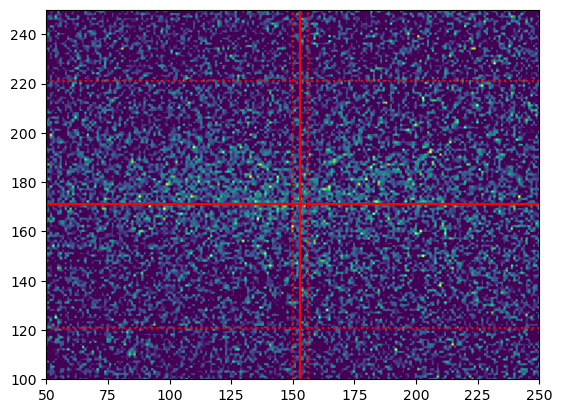

In [14]:
# determine optimal ROI
center = (171, 153)
h = 50
w = 3

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [15]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 73/73 [100%] in 18.0s (4.05/s)       
CPU times: total: 7.34 s
Wall time: 18 s


In [16]:
var_vals[0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

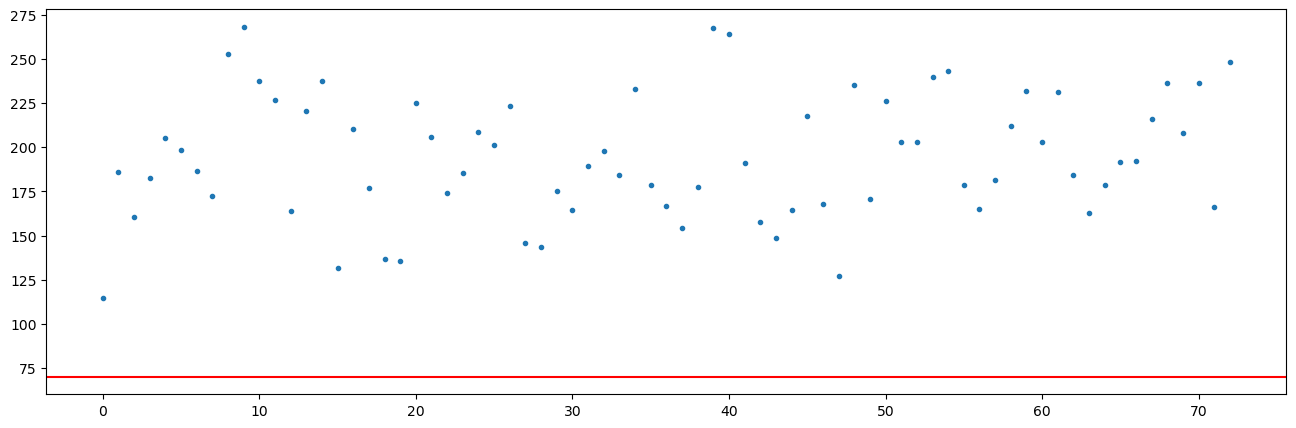

In [17]:
# filter out missed shots
bol = []

for rate in var_vals[0]:

    for i, im in images_prc[images_prc["i"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(70, c = "r")

plt.ylim(None, None)

plt.show()

In [18]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 70)

CPU times: total: 0 ns
Wall time: 12.6 ms


In [19]:
# plt.imshow((images_fil.iloc[0]["density"] +
#             images_fil.iloc[1]["density"] +
#             images_fil.iloc[2]["density"] +
#             images_fil.iloc[3]["density"] +
#             images_fil.iloc[4]["density"] +
#             images_fil.iloc[5]["density"] +
#             images_fil.iloc[6]["density"] +
#             images_fil.iloc[7]["density"])/8, vmin = 0, vmax = 3, cmap = "viridis")
#
# plt.xlim(125, 175)
# plt.ylim(100, 250)
#
# plt.show()

In [20]:
# plt.imshow(images_fil["density"].mean(numeric_only = False), vmin = 0, vmax = 3, cmap = "viridis")
#
# plt.xlim(125, 175)
# plt.ylim(100, 250)
#
# plt.show()

In [23]:
from scipy import constants as const
import pandas as pd
import numpy.ma as ma

omega_T4 = 2 * const.pi * 27.3 # angular frequency of T4 harmonic [Hz]
m_Li = 9.9883414e-27           # mass of lithium [kg]
px_to_x = 1.09739368998628e-6  # effective pixel size in [m]

wl_laser = 671e-9  # resonant wavelength for imaging
sigma_factor = 1
sigma_zero = 3 * (wl_laser ** 2) / (2 * np.pi)
sigma_eff = sigma_factor * sigma_zero

A = px_to_x**2  # pixel size in m**2
gain = 1

def masked_variance(images):

    stacked_images = ma.stack(images)
    variance = ma.var(stacked_images, axis = 0)

    return variance



def group(images, keys, key_kill, Csat_rate, illumination_time):
    """
    Function:
        This function averages the densities for all combinations of loop variables with respect to the variable
        'key_kill'. The averaging is usually performed over the iterations such that 'key_kill' = 'i',
        though it can be any of the loop variables. The averaging is done by grouping the entries in the input
        dataframe by the loop variables meant to be kept and averaging over the densities in the respective groups.

    Arguments:
        images            -- {pandas dataframe} densities for all combinations of loop variables filtered for missed shots
        keys              -- {array-like} keys of all loop variables
        key_kill          -- {string} loop variable to be averaged over and "killed" from the dataframe
        Csat_rate         -- {scalar} saturation rate value for imaging
        illumination_time -- {scalar} imaging illumination time [s]

    Returns:
        {pandas dataframe} densities for all combinations of loop variables averaged over key_kill
    """

    counts_sat = Csat_rate * illumination_time * 1e6

    key_group = keys.copy()
    key_group.remove(key_kill)

    if len(keys) == 1:

        images_grp = {}

        # averages
        images_grp["density"] = [images["density"].mean(numeric_only = False)]
        images_grp["atoms"] = [images["atoms"].mean(numeric_only=False)]
        images_grp["bright"] = [images["bright"].mean(numeric_only=False)]

        images_grp["atoms_var"] = [np.std(images["atoms"].to_numpy())**2]
        images_grp["bright_var"] = [np.std(images["bright"].to_numpy())**2]
        images_grp["fringe_var"] = [images_grp["bright_var"][0] - gain * images_grp["bright"][0]]

        images_grp = pd.DataFrame(images_grp)

        # for key in list(images_grp):
        #     if key not in key_group:
        #
        #         images_grp[key + "_var"] = images[key].apply(masked_variance)

    else:

        # group by group keys, calculate mean of densities, reshape dataframe to grouped dataframe
        images_grp = images.groupby(key_group).mean(numeric_only = False).reset_index().drop(columns = key_kill)

        for key in list(images_grp):
            if key not in key_group:

                variance = images.groupby(key_group)[key].apply(masked_variance).reset_index().drop(columns = key_group, axis = 1)

                variance.rename(columns = {key: key + "_var"}, inplace=True)
                images_grp = pd.concat([images_grp, variance], axis = 1).reindex(images_grp.index)

    images_grp["fringe_var"] = images_grp["bright_var"] - gain * images_grp["bright"]

    images_grp["number_var"] = ((A / sigma_eff * (1 / images_grp["atoms"] + 1 / counts_sat)) ** 2 *
                                (images_grp["atoms_var"] - gain * images_grp["atoms"] - images_grp["fringe_var"]))

    return images_grp

In [24]:
%%time
# group by loop variables and average over iterations
images_grp = group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

CPU times: total: 1.89 s
Wall time: 2.06 s


In [25]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 46.9 ms
Wall time: 59.5 ms


In [26]:
%%time
# calculate response
# images_res = la.response(images_fit)

CPU times: total: 0 ns
Wall time: 0 ns


# Visualization

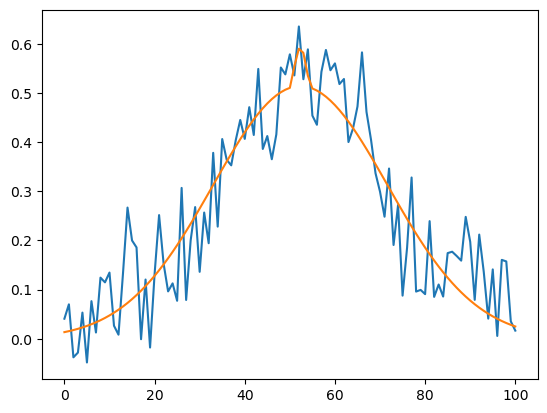

[19.64767177870937, 1.5629311414959777]


In [35]:
field = 3

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["temperature"].iloc[field])

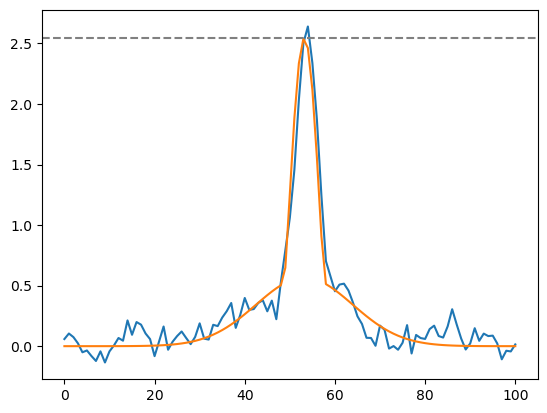

Temperature 6.00 +- 0.88 nK
[  0.56596235  53.76083684 233.91020137   1.98029471   4.65337499]



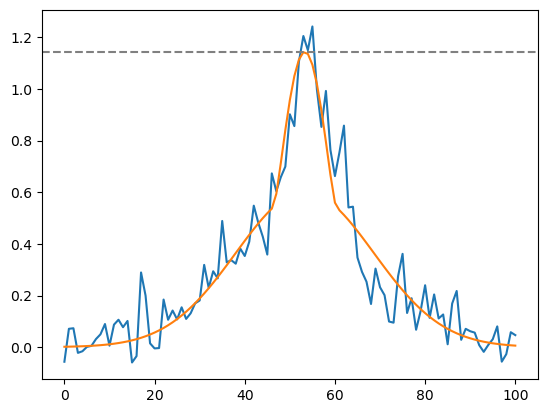

Temperature 12.26 +- 1.31 nK
[  0.60132926  53.85158912 478.32205704   0.54322844   7.0484947 ]



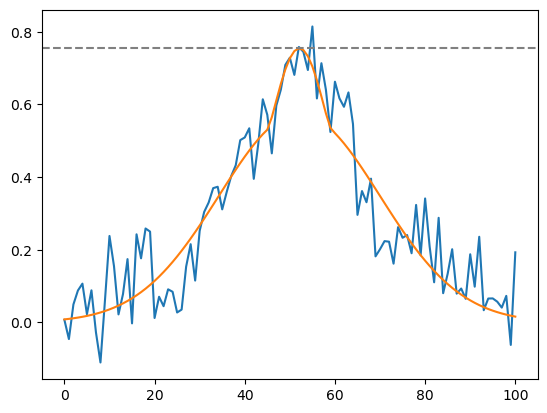

Temperature 16.69 +- 1.55 nK
[5.74033458e-01 5.26381270e+01 6.50915521e+02 1.80405297e-01
 7.15904109e+00]



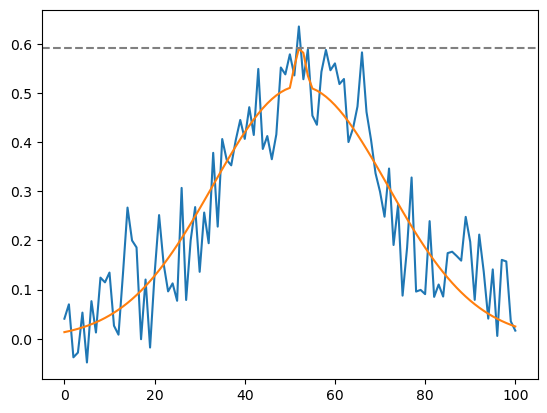

Temperature 19.65 +- 1.56 nK
[5.14114479e-01 5.28438338e+01 7.66462746e+02 7.83904706e-02
 2.26438375e+00]



In [36]:
for i, im in images_fit.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][0],
                                                              im["T4_params"][1],
                                                              im["T4_params"][2],
                                                              im["T4_params"][3],
                                                              im["T4_params"][4],))

    # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
    plt.axhline(im["T4_peak"], color = "grey", ls = "--")

    plt.show()

    # print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
    print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")
    print(im["T4_params"])
    print("")

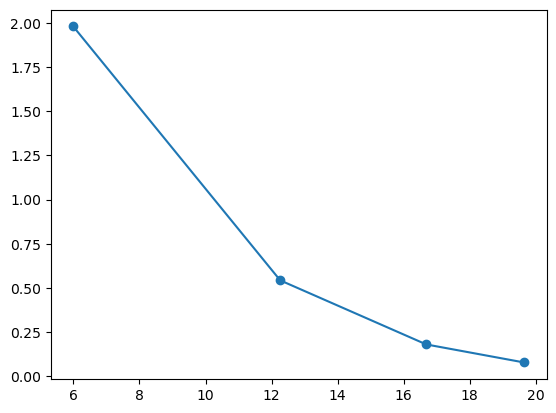

In [37]:
peeeek = []
TTT = []

for i, im in images_fit.iterrows():
    peeeek.append(im["T4_params"][-2])
    TTT.append(im["temperature"][0])

plt.scatter(TTT, peeeek)
plt.plot(TTT, peeeek)

plt.show()


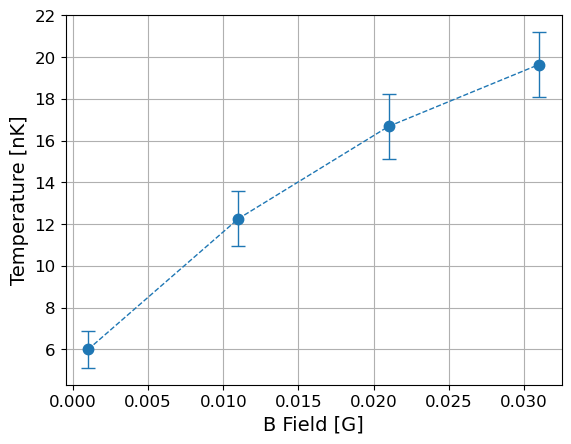

In [39]:
B = np.array(images_fit["Acc_hold_time"].tolist())
T = np.array(images_fit["temperature"].tolist())

plt.errorbar(B, T[:, 0], T[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel("B Field [G]", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(visible = True, which = "both")

plt.show()

In [28]:
omega_T4 = 2 * const.pi * 27.3 # angular frequency of T4 harmonic [Hz]
m_Li = 9.9883414e-27           # mass of lithium [kg]
px_to_x = 1.09739368998628e-6  # effective pixel size in [m]

TTT = 300 * px_to_x**2 * m_Li * omega_T4**2 / const.k * 1e9

sigma = 30 * (px_to_x**2 * m_Li * omega_T4**2 / const.k * 1e9)**(-1)

# print(TTT)
print(sigma)

1170.3107955320947
